# Data Analysis for creating a model for clustering predicted genomes
The goal for this notebook was to perform analysis of clustered genomes. 

In [122]:
import pickle as pickle
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt

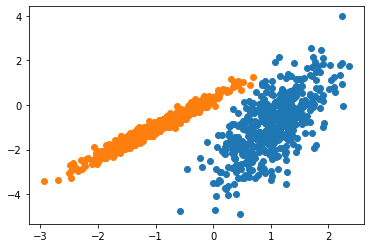

In [123]:
# define dataset
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = GaussianMixture(n_components=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

# Exploring the dataset

### STEPS:

1. Load the dataset
2. parse the dataset into vectors
3. Plot a scatter plot for the data
4. Gaussian Mixture model

In [142]:
# load dataset
dataset = pickle.load(open("merge_overlap_out_minimap_out.pickle","rb" ))

In [161]:

from typing import Dict, Union, List, Tuple,Optional
# Exploring the averages for the datasets.
def print_values_for_mappedinfo(dataset: Dict[str,Dict[str, Union[set, int, float]]]) -> Tuple[List[float]]:
    """ 
    takes in the pickle output from the MergeOverlap and prints metrics 
    
    :input (Dict[str,Dict[str, Union[set, int, float]]]):
        The input is a nested dicitonary containing information from the
        primary data structure generated during MergeOverlap. This is
        put into a pickle file and used for data analysis here.
        
    :output (tuple[List[float]):
        1. np.array(y_vector) - a vector containing the names for the phages
        2. np.array(x_vector) - a vector containing a 2D vector of [mapq, overlapmerge percentage]
    """
    y_vector = []
    x_vector = []
    for index, genome in enumerate(dataset.keys()):
        print("\n" + genome)
        y_vector.append(genome)
        x_vector.append([])
        for metric in dataset[genome].keys(): 
            if metric in ['mapq', 'readmaps', 'readcount']:
                print(f" {metric}: {np.average(dataset[genome][metric])}")
                if metric == 'mapq':
                    x_vector[index].append(np.average(dataset[genome][metric]))
            elif metric == "overlappMerge":
                print(f" {metric}: {len(dataset[genome][metric]) }")
            else:
                print(f" {metric}: {dataset[genome][metric]}")
                x_vector[index].append(dataset[genome][metric])
    return np.array(y_vector), np.array(x_vector)

y_vector, x_vector = print_values_for_mappedinfo(dataset)


Ryadel
 mapq: 40.428778766121674
 readmaps: 36313.79779326876
 readcount: 363796.0
 overlappMerge: 1
 percenOverlap: 1.0

Blessica
 mapq: 38.73105090262499
 readmaps: 36027.097721587656
 readcount: 33181.0
 overlappMerge: 97
 percenOverlap: 0.6925563173359451

Rockstar
 mapq: 43.733110603129944
 readmaps: 23917.73476600769
 readcount: 199045.0
 overlappMerge: 1
 percenOverlap: 0.9999790707408958

Paphu
 mapq: 31.57288649152599
 readmaps: 23266.38992524889
 readcount: 120132.0
 overlappMerge: 34
 percenOverlap: 0.7968294923669345

Perseus
 mapq: 41.227324869990824
 readmaps: 30093.744124095036
 readcount: 78456.0
 overlappMerge: 45
 percenOverlap: 0.9290391780512589


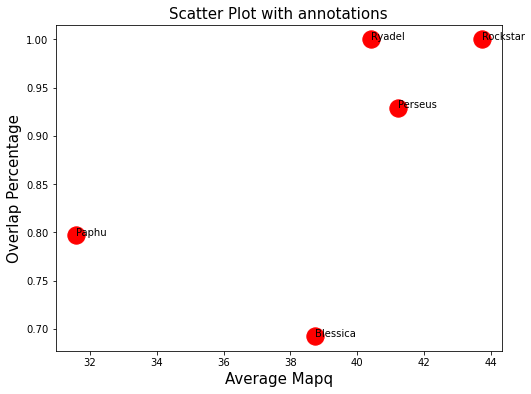

In [162]:
# plot a scatterplot of the data
plt.figure(figsize=(8,6))
plt.scatter(x_vector[:,0], x_vector[:,1], s=300,color="red")
plt.title("Scatter Plot with annotations",fontsize=15)
plt.ylabel("Overlap Percentage",fontsize=15)
plt.xlabel("Average Mapq",fontsize=15)
for i, label in enumerate(y_vector):
    plt.annotate(label, (x_vector[:,0][i], x_vector[:,1][i]))

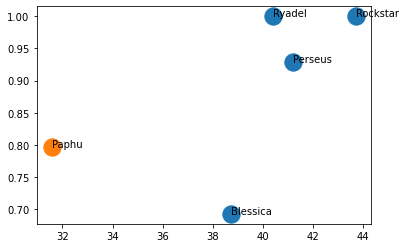

In [175]:
# Gaussian Mixture model
# define the model
model = GaussianMixture(n_components=2)
# fit the model
model.fit(x_vector)
# assign a cluster to each example
yhat = model.predict(x_vector)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    pyplot.scatter(x_vector[row_ix, 0], x_vector[row_ix, 1], s=300)
    for row in enumerate(row_ix):
        x = list(x_vector[row_ix, 0])[0]
        y = list(x_vector[row_ix, 1])[0]
        for i in range(len(x)):
            plt.annotate(y_vector[row_ix[0][i]], (x[i], y[i]))
# show the plot
pyplot.show()

In [197]:
from abc import ABC, abstractmethod

class TrueGenomeFinder(ABC):
    """ This is the abstract class for the unsupervised genome finder """

    @property
    @abstractmethod
    def model_name(self):
        """ getter for model name (encapsulation) """
        pass
    
    @property
    @abstractmethod
    def model(self):
        """ This is the model for the unsupervised classification """
        pass
    
    @abstractmethod
    def model_predict(self, x_vector):
        """
        Sine the model clusters data, there's not necessarily 
        a training set needed - it's practically just binary
        clustering. 
        """
        pass

class GaussianMixModel(TrueGenomeFinder):
    """ This is the abstract class for the unsupervised genome finder """
    
    def __init__(self):
        self.model = GaussianMixture(n_components=2)
        self.model_name = "Gassiaun Mixture Model"


#     def model(self):
#         """ This is the model for the unsupervised classification """
#         return GaussianMixture(n_components=2)
    
    def model_predict(self, x_vector):
        """
        Sine the model clusters data, there's not necessarily 
        a training set needed - it's practically just binary
        clustering. 
        """
        FIT_MODEL = self.model.fit(x_vector)
        return FIT_MODEL.predict(x_vector)
    
def get_true_positive(name_list, x_vector) -> Optional[str]:
    """
    Description:
        The goal for this method is to find a genome in the list of 
        genomes that is likely to be a part of the true cluster of genomes
        in the sample. An assumption used here is that the best genome will
        have a high mapq average and a high mergeoverlap percentage. 
    Input:
        1. name_list
        2. x_vector
                [mapq, overlap percentage]
    Output:
        1. High probability candidate name (str)
    """
    max_score = 0
    high_prob_genome = None
    for row_number, values in enumerate(x_vector):
        mapq = values[0]
        overlap_percentage = values[1]
        score = (mapq / 60) + overlap_percentage
        print(score)
        if score > max_score:
            max_score = score
            high_prob_genome = name_list[row_number]
    return high_prob_genome
    

def get_filtered_genomes(true_positive_name, model,  name_list):
    """
    Description:
        This method takes in a genome with the highest confidence 
        of being true, and collects all other genomes in the same
        bin. 
    Input:
        1. true_positive_name (str) - a name of a genome known to be true.
        2. model - a vector of 0s and 1s inidicating the binary clusters
                    NOTE: should have same order as the name list.
        3. name_list (List[str]) - 
    """
    cluster = None
    for index, name in enumerate(name_list):
        if name == true_positive_name: 
            cluster = model[index]
    return [name_list[index] for index, val in enumerate(model) if val == cluster]
    
yhat = GaussianMixModel().model_predict(x_vector)
true_pos_genome = get_true_positive(y_vector, x_vector)
print(f"true positive genome: {true_pos_genome}")
get_filtered_genomes(true_positive_name=true_pos_genome, model=yhat, name_list=y_vector)

TypeError: Can't instantiate abstract class GaussianMixModel with abstract methods model, model_name